__Curate longitudinal dataset based on Ann-Kathrins pathology labels__

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import mne
import pandas as pd
import numpy as np

from braindecode.datasets.base import BaseDataset, BaseConcatDataset

from decode_tueg import extract_longitudinal_dataset, plot_longitudinal_interval_hists

In [28]:
description = pd.read_csv('/home/jovyan/mne_data/TUH/final_tuabEx_description.csv', index_col=0)
description.shape

(33660, 18)

In [ ]:
(description.n_samples/description.sfreq).min()

In [ ]:
df = extract_longitudinal_dataset(description, kind='transition', load=False)

In [142]:
df = extract_longitudinal_dataset(description, 'pathological', False)

n recs 18338 n subj 2892


In [136]:
df = extract_longitudinal_dataset(description, 'non_pathological', False)

n recs 4068 n subj 956


In [4]:
ds = extract_longitudinal_dataset(description, 'transition', True)

n recs 3357 n subj 525


In [6]:
with open('/home/jovyan/longitudinal/transition.pkl', 'wb') as f:
    pickle.dump(ds, f)

In [7]:
ds = extract_longitudinal_dataset(description, 'non_pathological', True)

n recs 4068 n subj 956


In [8]:
with open('/home/jovyan/longitudinal/non_pathological.pkl', 'wb') as f:
    pickle.dump(ds, f)

In [9]:
ds = extract_longitudinal_dataset(description, 'pathological', True)

n recs 18338 n subj 2892


In [10]:
with open('/home/jovyan/longitudinal/pathological.pkl', 'wb') as f:
    pickle.dump(ds, f)

__Plot longitudinal datasets__

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import torch
import numpy as np
import pandas as pd
from skorch.callbacks import Checkpoint
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set_color_codes('deep')

from braindecode.preprocessing import Preprocessor, preprocess
from braindecode import EEGRegressor
from braindecode.models import ShallowFBCSPNet

# from decode_tueg import _create_windows as create_windows

/tmp/ipykernel_221/396139984.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def plot_age_hist2(description, ax=None, hue_key=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 2))
    sns.histplot(
        data=description,
        bins=np.linspace(0,100,101,dtype=int),
        x='age',
        kde=True,
        ax=ax,
        hue=hue_key if description[hue_key].nunique() != 1 else None,
        palette=['b', 'r'] if description[hue_key].nunique() != 1 else None,
        color='r' if 0 not in description[hue_key].unique() else 'b',
    );
    return ax
    #ax.set_title(f'train (n={len(train_set.datasets)})')
    #fig.savefig('/home/jovyan/train_dist_wo_gender.jpg', bbox_inches='tight')

In [5]:
workspace = ''  # workspace-tueg

In [6]:
with open(f'/home/jovyan/{workspace}/longitudinal/transition.pkl', 'rb') as f:
    ds = pickle.load(f)

In [9]:
ds.description.groupby('subject').head(1).gender.value_counts()

F    275
M    250
Name: gender, dtype: int64

In [44]:
n_channels = len(ds[0][0])

Text(0, 0.5, 'Count')

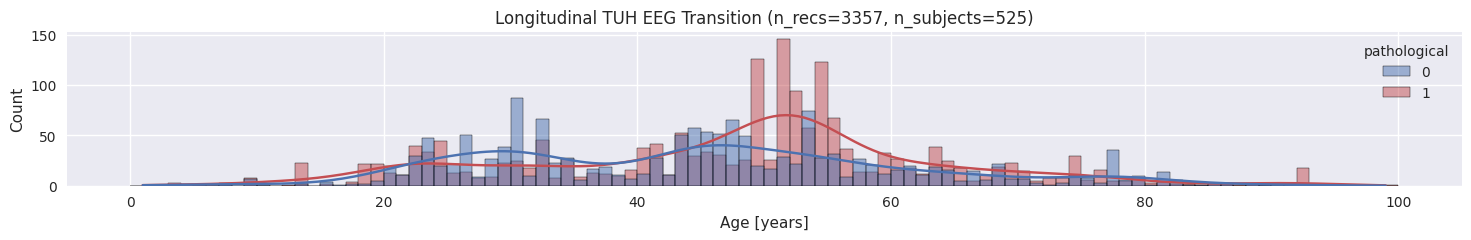

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Transition (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/transition_hist.jpg', bbox_inches='tight', dpi=300)

In [10]:
with open(f'/home/jovyan/{workspace}/longitudinal/non_pathological.pkl', 'rb') as f:
    ds = pickle.load(f)

In [13]:
ds.description.groupby('subject').head(1).gender.value_counts()

F    554
M    402
Name: gender, dtype: int64

In [36]:
for n, g in ds.description.groupby('subject'):
    assert g.pathological.nunique() == 1

Text(0, 0.5, 'Count')

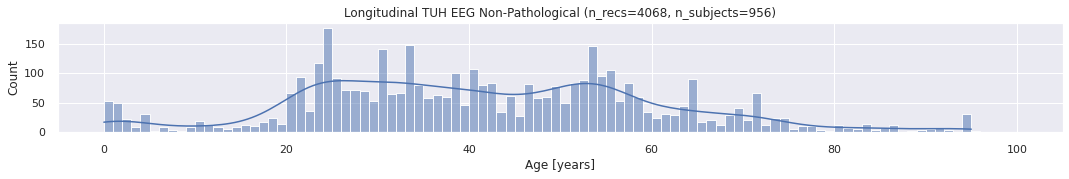

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Non-Pathological (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/non_pathological_hist.jpg', bbox_inches='tight', dpi=300)

In [16]:
with open(f'/home/jovyan/{workspace}/longitudinal/pathological.pkl', 'rb') as f:
    ds = pickle.load(f)

In [20]:
ds.description.groupby('subject').head(1).gender.value_counts()

M    1478
F    1414
Name: gender, dtype: int64

In [184]:
for n, g in ds.description.groupby('subject'):
    assert g.pathological.nunique() == 1

Text(0, 0.5, 'Count')

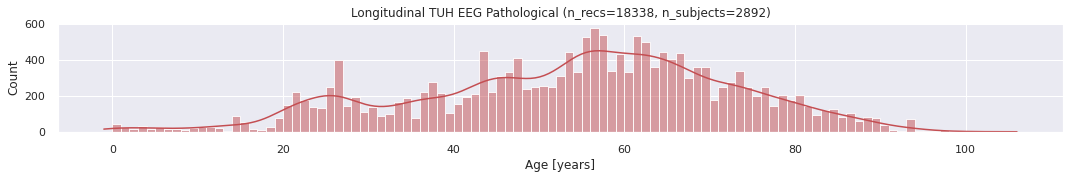

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Pathological (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/pathological_hist.jpg', bbox_inches='tight', dpi=300)

In [22]:
import seaborn as sns
sns.set(color_codes=True)

In [23]:
from decode_tueg import age_pyramid

In [97]:
df = ds.description[['pathological', 'gender', 'age', 'subject']]
df['gender'] = df['gender'] == 'F'

In [75]:
df.shape

(3357, 4)

In [76]:
len(df.subject.unique())

525

In [77]:
for n, g in df.groupby(['gender', 'pathological']):
    print(n, g.shape)
    print(n, len(g.subject.unique()))
    print()

(False, 0) (654, 4)
(False, 0) 250

(False, 1) (786, 4)
(False, 1) 251

(True, 0) (855, 4)
(True, 0) 275

(True, 1) (1062, 4)
(True, 1) 275



In [78]:
855+1062+654+786

3357

In [79]:
275+250

525

In [80]:
# why has male non-pathological 250 and male pathological 251? should not happen! this is the transition dataset
# every subject should appear in pathological and non-pathological

In [87]:
subject_wise = False

In [88]:
df.groupby(['subject', 'pathological'], as_index=False).mean() if subject_wise else df

,pathological,gender,age,subject
0,1,False,49,5
1,1,False,49,5
2,1,False,50,5
3,0,False,51,5
4,1,False,52,5
...,...,...,...,...
3352,1,True,43,14951
3353,1,True,43,14951
3354,1,True,43,14951
3355,1,True,43,14951


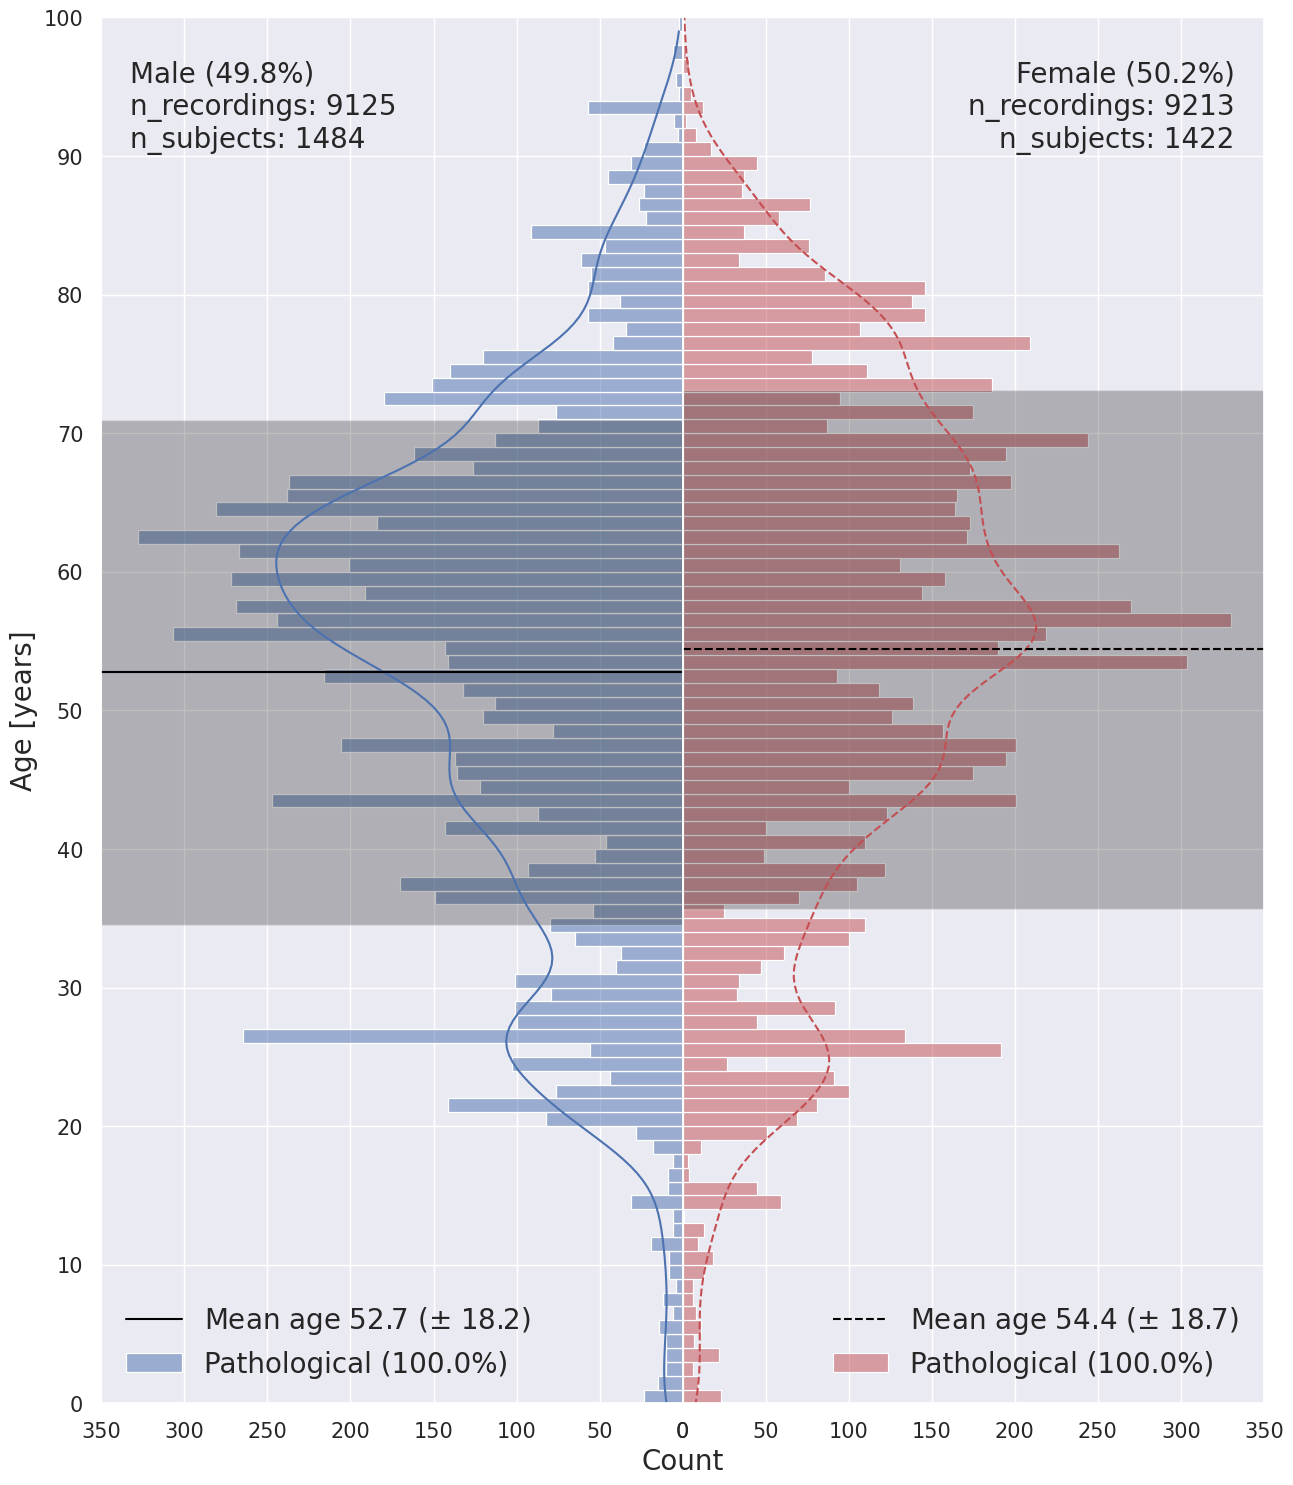

In [102]:
s = 'Recording' if not subject_wise else 'Subject'
ax = age_pyramid(
    df.groupby(['subject', 'pathological'], as_index=False).mean() if subject_wise else df, 
    f'Longitudinal Pathological {s}', 
    ylim=350 if not subject_wise else 22,
#     ylim=50,
    show_title=False,
    fs=20,
    #out_dir='/home/jovyan/', 
)
# ax.title(f'n_reorcings: {len(ds.datasets)}, n_subjects: {ds.description["subject"].nunique()}')
ax[0].get_figure().savefig('/home/jovyan/workspace-tueg/longitudinal_pathological_histogram.png', 
                           dpi=300, bbox_inches='tight')

In [90]:
print("hi")

hi


In [21]:
# analyze time delta between recs of a subject

In [22]:
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')

/tmp/ipykernel_221/3273306663.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [23]:
from decode_tueg import plot_longitudinal_interval_hists

In [24]:
# TODO: compute on session level as multiple recs in one session could bias average time?
# TODO: compute median as outliers could bias average time?

n recs 18338 n subj 2892
[1] 77.39764340282274 361.3859515812329
n recs 4068 n subj 956
[0] 110.46433161953728 475.90659495679597
n recs 3357 n subj 525
[1 0] 214.64583333333334 609.9279473375719


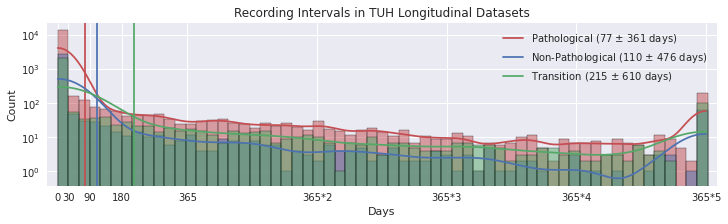

In [30]:
# this uses entire tuabex description
ax = plot_longitudinal_interval_hists(description)
# ax.get_figure().savefig('/home/jovyan/recording_intervals.jpg', dpi=300, bbox_inches='tight')

n recs 18338 n subj 2892
[1] 77.39764340282274 361.3859515812329
n recs 4068 n subj 956
[0] 110.46433161953728 475.90659495679597
n recs 3357 n subj 525
[1 0] 214.64583333333334 609.9279473375719


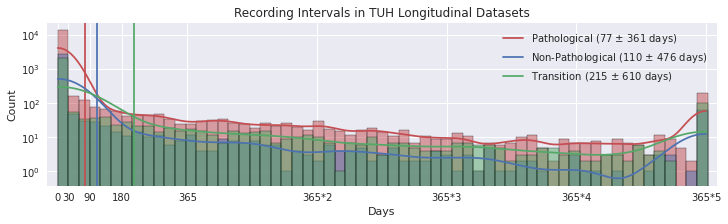

In [6]:
ax = plot_longitudinal_interval_hists(description)
# ax.get_figure().savefig('/home/jovyan/recording_intervals.jpg', dpi=300, bbox_inches='tight')